# 集成算法
- Bagging:训练多个分类器取平均
    - $f(x)=\frac{1}{M} \sum_{m=1}^{M} f_m(x)$
- Boosting:训练多个分类器，每个分类器对前一个分类器的错误进行修正(从弱学习器开始加强，通过加权来训练)
    - $ F_m(x) = F_{m-1}(x) + \mathop{\mathrm{argmin}}_h \sum_{i=1}^n L\bigl(y_i, F_{m-1}(x_i) + h(x_i)\bigr) $ 
- Stacking:聚合多个分类器或回归模型（可以分段来做） 
## Bagging模型
- 典型代表：随机森林
    - 随机采样
    - 随机特征
    - 多个决策树并行放在一起 
    - 优势
        - 可解释性强
        - 自动选择优异特征
        - 适合处理高维度的数据
## Boosting模型
- 典型代表：GBDT,AdaBoost，XgBoost, LGBM(越后面效果越好)
## Stacking模型
- 堆叠：很暴力，拿来一堆直接上（各种分类器都来了）
- 分阶段：第一阶段得出各自结果，第二阶段再用前一阶段结果训练


In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.family']=['SimHei','Times New Roman']
plt.rcParams['axes.unicode_minus']=False
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

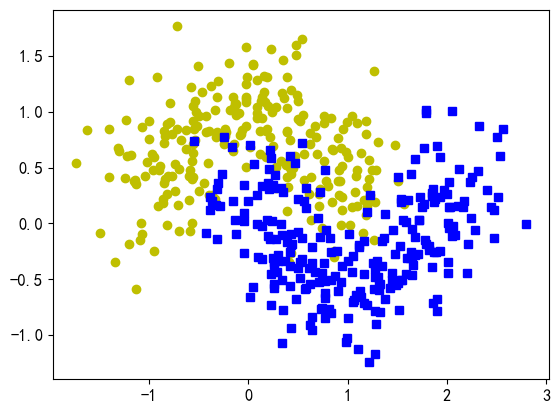

In [4]:
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")

## 投票策略
- 软投票：直接用类别值，少数服从多数
- 硬投票：各自分类器的概率值进行加权平均

硬投票实验

In [7]:
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)
rnd_clf = RandomForestClassifier()
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [ ]:
voting_clf.fit(X_train, y_train)

In [11]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.904


软投票实验

In [12]:
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
svm_clf = SVC(gamma="scale", random_state=42, probability=True)
rnd_clf = RandomForestClassifier(random_state=42)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

In [13]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


Bagging和决策树对比实验
- 随机森林决策边界流畅光滑更简单一些

In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.904
0.856


In [15]:
from matplotlib.colors import ListedColormap
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    plt.contour(x1, x2, y_pred, alpha=0.3)
    if contour:
        cusomt_cmap2 = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
        plt.contourf(x1, x2, y_pred, alpha=0.8, cmap=cusomt_cmap2)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18)

Text(0.5, 1.0, 'Decision Trees with Bagging')

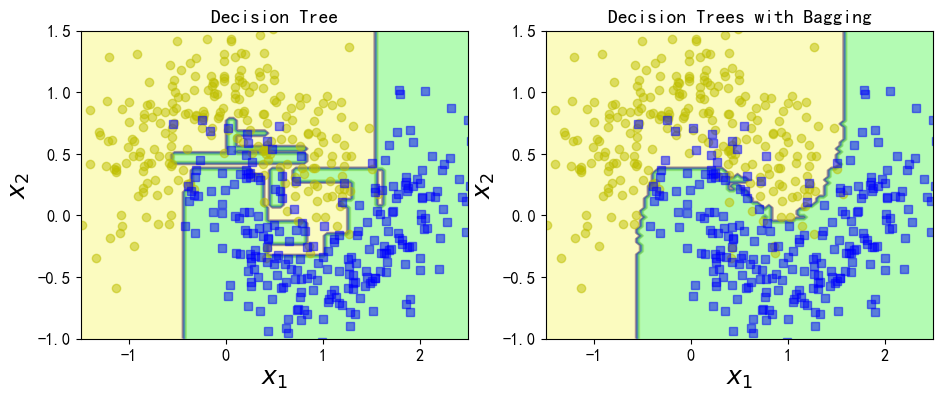

In [16]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)

OOB（out of bag）策略
- 使用类似交叉验证的方法

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42,oob_score= True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9253333333333333

In [19]:
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.904


In [20]:
bg_data=bag_clf.oob_decision_function_
bg_data.shape,bg_data

((375, 2),
 array([[0.35579515, 0.64420485],
        [0.43513514, 0.56486486],
        [1.        , 0.        ],
        [0.01030928, 0.98969072],
        [0.03174603, 0.96825397],
        [0.07672634, 0.92327366],
        [0.39189189, 0.60810811],
        [0.06145251, 0.93854749],
        [0.92689295, 0.07310705],
        [0.88205128, 0.11794872],
        [0.59850374, 0.40149626],
        [0.04896907, 0.95103093],
        [0.7565445 , 0.2434555 ],
        [0.81377551, 0.18622449],
        [0.88528678, 0.11471322],
        [0.07407407, 0.92592593],
        [0.04738155, 0.95261845],
        [0.92051282, 0.07948718],
        [0.69974555, 0.30025445],
        [0.94358974, 0.05641026],
        [0.06100796, 0.93899204],
        [0.224     , 0.776     ],
        [0.9125964 , 0.0874036 ],
        [0.98746867, 0.01253133],
        [0.95967742, 0.04032258],
        [0.        , 1.        ],
        [0.94255875, 0.05744125],
        [1.        , 0.        ],
        [0.03466667, 0.96533333],
   

随机森林
- 特征的重要性

In [23]:
from sklearn.datasets import load_iris
iris=load_iris()
rf_clf=RandomForestClassifier(n_estimators=500,n_jobs=-1)
rf_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rf_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.08982792746840501
sepal width (cm) 0.02255328000441827
petal length (cm) 0.4474518333481164
petal width (cm) 0.4401669591790604


In [33]:
from sklearn.datasets import fetch_openml
# 从 OpenML 获取 MNIST 数据集
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [34]:
rf_clf=RandomForestClassifier(n_estimators=500,n_jobs=-1)
rf_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [35]:
rf_clf.feature_importances_.shape

(784,)

[Text(1, 0.0, 'Not important'), Text(1, 0.00979870440222279, 'Very important')]

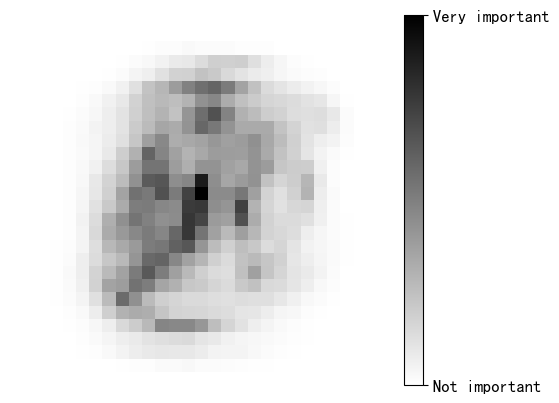

In [42]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.get_cmap("binary"))
    plt.axis("off")
plot_digit(rf_clf.feature_importances_)
char=plt.colorbar(ticks=[rf_clf.feature_importances_.min(), rf_clf.feature_importances_.max()])
char.ax.set_yticklabels(['Not important', 'Very important'])

Boosting-提升策略
- AdaBoost
- 样品权重增加的方式，进行提升策略

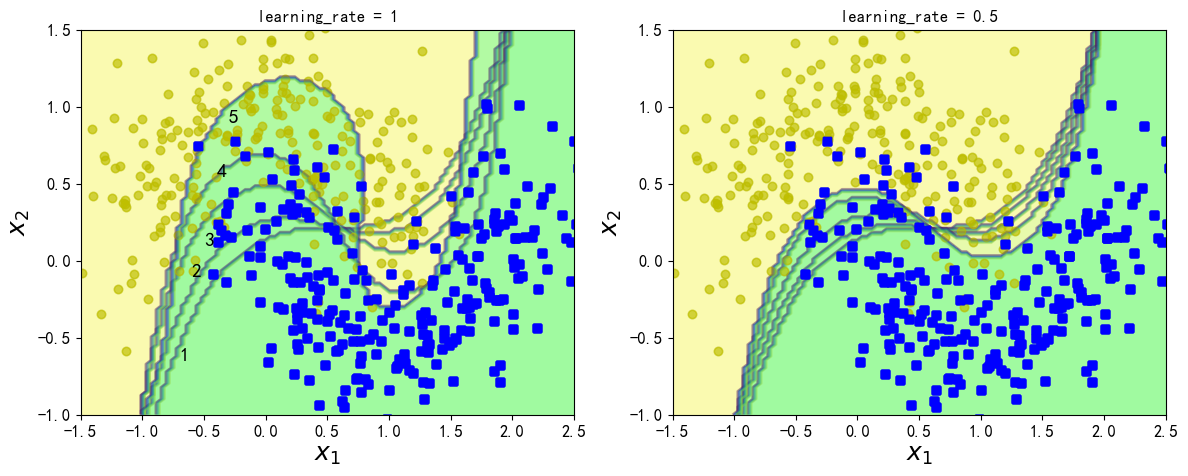

In [45]:
m = len(X_train)
plt.figure(figsize=(14,5))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf=SVC(kernel='rbf',C=0.05,random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1+learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title(f'learning_rate = {learning_rate}')
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
    if subplot==121:
        plt.text(-0.7,-0.65,'1', fontsize=14)
        plt.text(-0.6,-0.1,'2', fontsize=14)
        plt.text(-0.5,0.1,'3', fontsize=14)
        plt.text(-0.4,0.55,'4', fontsize=14)
        plt.text(-0.3,0.9,'5', fontsize=14)
plt.show()

In [48]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf=AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,learning_rate=0.5, random_state=42)

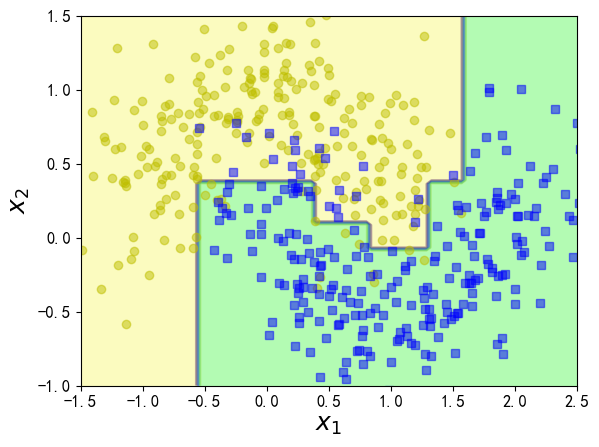

In [49]:
ada_clf.fit(X_train, y_train)
plot_decision_boundary(ada_clf, X, y)

Gradient Boosting(梯度提升树）

In [59]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:,0]**2 + 0.05 * np.random.randn(100)

In [60]:
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [61]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [62]:
y3= y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [63]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
print(y_pred)

[0.75026781]


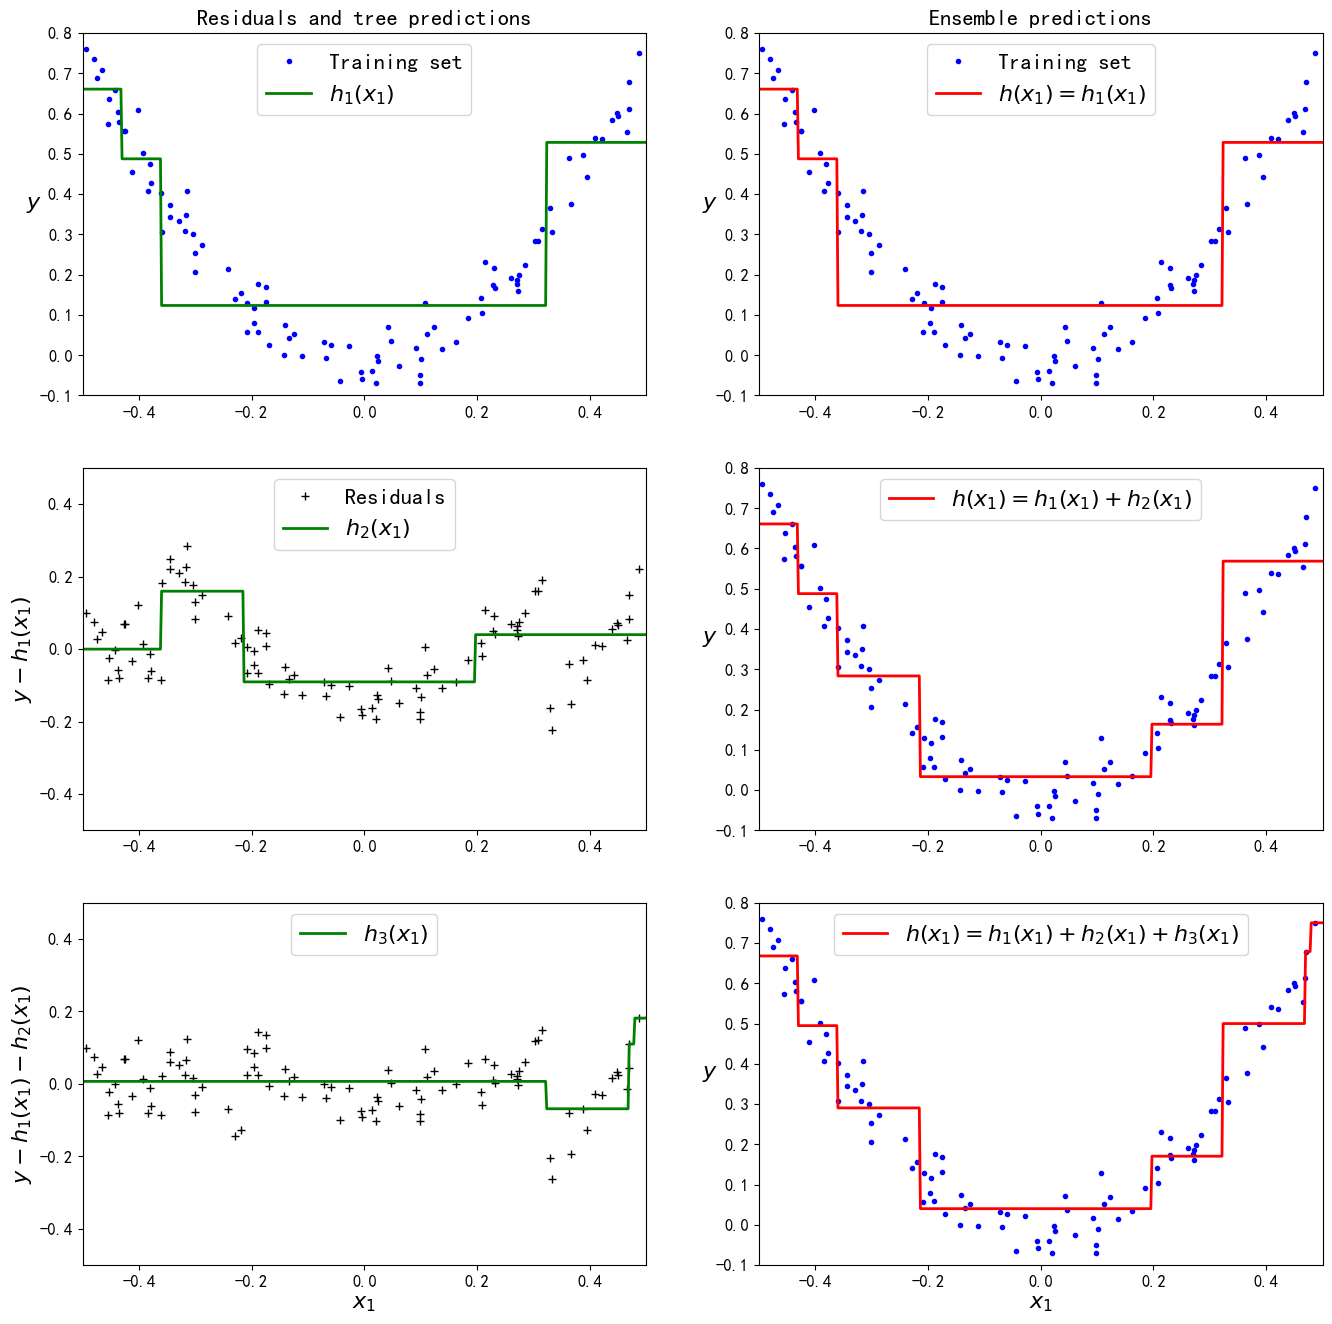

In [70]:
def plot_predictions(models, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = sum(model.predict(x1) for model in models)
    plt.plot(X, y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)
    return plt
# 绘图逻辑（对应你提供的截图代码）
plt.figure(figsize=(16, 16))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], 
                 label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], 
                 label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In [71]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0,
                                 random_state=42)
gbrt.fit(X, y)

gbrt_slow_1 = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1,
                                 random_state=42)
gbrt_slow_1.fit(X, y)


GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

In [84]:

gbrt_slow_2 = GradientBoostingRegressor(max_depth=2, n_estimators=50, learning_rate=0.1,
                                 random_state=42)
gbrt_slow_2.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=50, random_state=42)

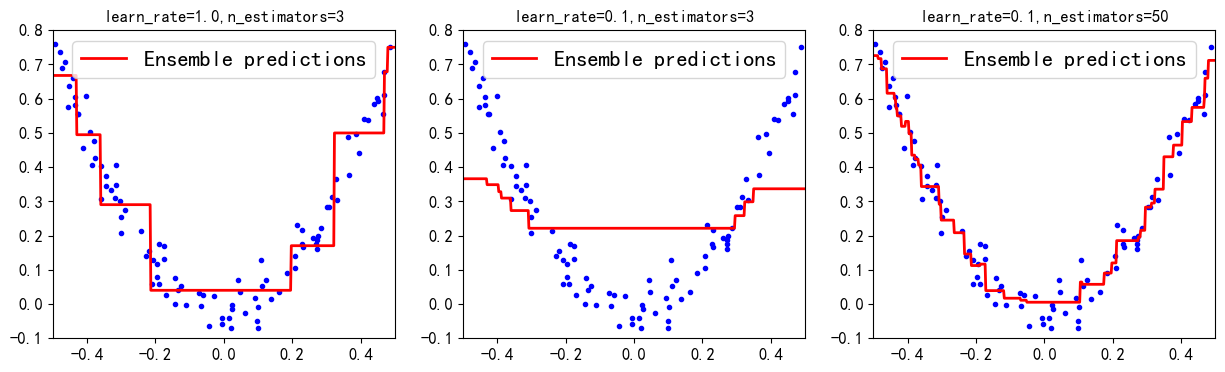

In [85]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title('learn_rate={},n_estimators={}'.format(gbrt.learning_rate, gbrt.n_estimators))

plt.subplot(132)
plot_predictions([gbrt_slow_1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title('learn_rate={},n_estimators={}'.format(gbrt_slow_1.learning_rate, gbrt_slow_1.n_estimators))

plt.subplot(133)
plot_predictions([gbrt_slow_2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title('learn_rate={},n_estimators={}'.format(gbrt_slow_2.learning_rate, gbrt_slow_2.n_estimators))
plt.show()

提前停止策略，放在随着迭代次数增加，损失值发生反弹

In [100]:
from sklearn.metrics import mean_squared_error
X_train,X_val,y_train,y_val = train_test_split(X,y,random_state=49)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, learning_rate=0.1, random_state=49)
gbrt.fit(X_train,y_train)
errors = [mean_squared_error(y_val,y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, learning_rate=0.1, random_state=49)
gbrt_best.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=np.int64(55),
                          random_state=49)

In [101]:
min_error = np.min(errors)
min_error

np.float64(0.002712853325235463)

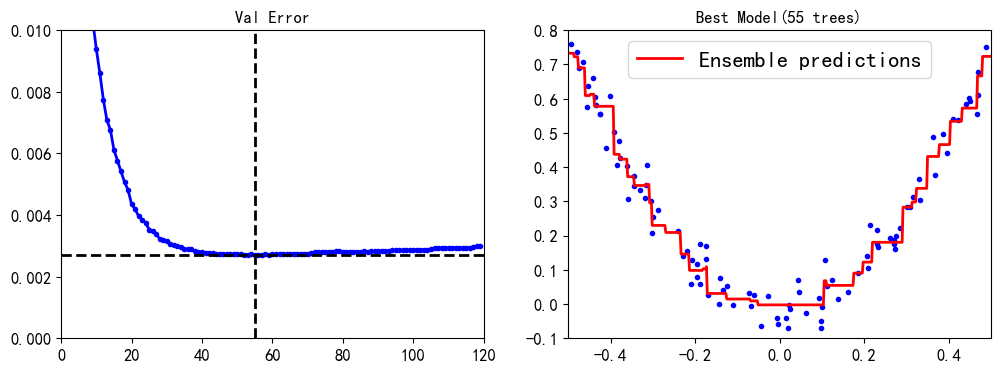

In [102]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(errors, "b.-", linewidth=2, label="Training set")
plt.plot([bst_n_estimators, bst_n_estimators], [0, 0.05], "k--", linewidth=2, label="Val set")
plt.plot([0,120], [min_error, min_error], "k--", linewidth=2)
plt.title("Val Error")
plt.axis([0, 120, 0, 0.01])
plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title('Best Model(%d trees)'%bst_n_estimators)
plt.show()

停止器

In [107]:
gbrt = GradientBoostingRegressor(max_depth=2, learning_rate=0.1, random_state=49,warm_start=True)
error_going_up = []
min_val_error = float("inf")
best_n_estimators=0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up=0
        best_n_estimators = n_estimators
    else:
        error_going_up += 1
        if error_going_up == 5:
            break
print(best_n_estimators)

56


In [108]:
print(gbrt.n_estimators)

61


Stacking(堆叠集成）
- ![](img/img_7.png)

In [109]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# 加载 MNIST 数据集（替代 fetch_mldata）
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# 拆分数据集：先拆训练验证集+测试集
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42
)
# 再拆训练集+验证集
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42
)

In [111]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

random_forest_clf = RandomForestClassifier(random_state=42)
extra_trees_clf = ExtraTreesClassifier(random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]

for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(random_state=42)
Training the MLPClassifier(random_state=42)


In [112]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)
for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

# 4. 训练 blender 模型（对应第二张截图）
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [113]:
rnd_forest_blender.oob_score_

0.9696